In [1]:
import os
signal_list=[]
for filename in os.listdir("SMC_WatchSpO2_deliverable_241226/SMC_WatchSpO2_deliverable_241226"):
    print(filename)

.DS_Store
watch4
watch5
watch6
watch7


In [2]:

directory="SMC_WatchSpO2_deliverable_241226/SMC_WatchSpO2_deliverable_241226"

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_dict = {}
device_names = ['GW4','GW5','GW6','GW7']
for device_name in device_names:
    path = os.path.join(directory, 'watch' + device_name[-1])
    GW = os.listdir(path)
    GW.sort()
    for file_name in GW:
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path)
        if device_name == 'GW4':
            try:
                patient = 'GW4' + file_name.split('SUB_SMC_')[1].split('_')[0]
            except Exception:
                continue
        else:
            try:
                patient_id = file_name.split('_Id')[1].split('_')[0]
                patient = 'GW' + device_name[-1] + patient_id[-3:]
            except Exception:
                continue
        signal = df['SpO2'].values
        zero_count = np.sum(signal == 0)
        if patient not in df_dict or zero_count < df_dict[patient][1]:
            df_dict[patient] = (signal, zero_count)
df_list = [(signal, patient) for patient, (signal, _) in df_dict.items()]
print(f"length of df_list {len(df_list)}")

length of df_list 390


Minimum signal length: 17028
Prepared 100 signals of length 17028 for SSL training


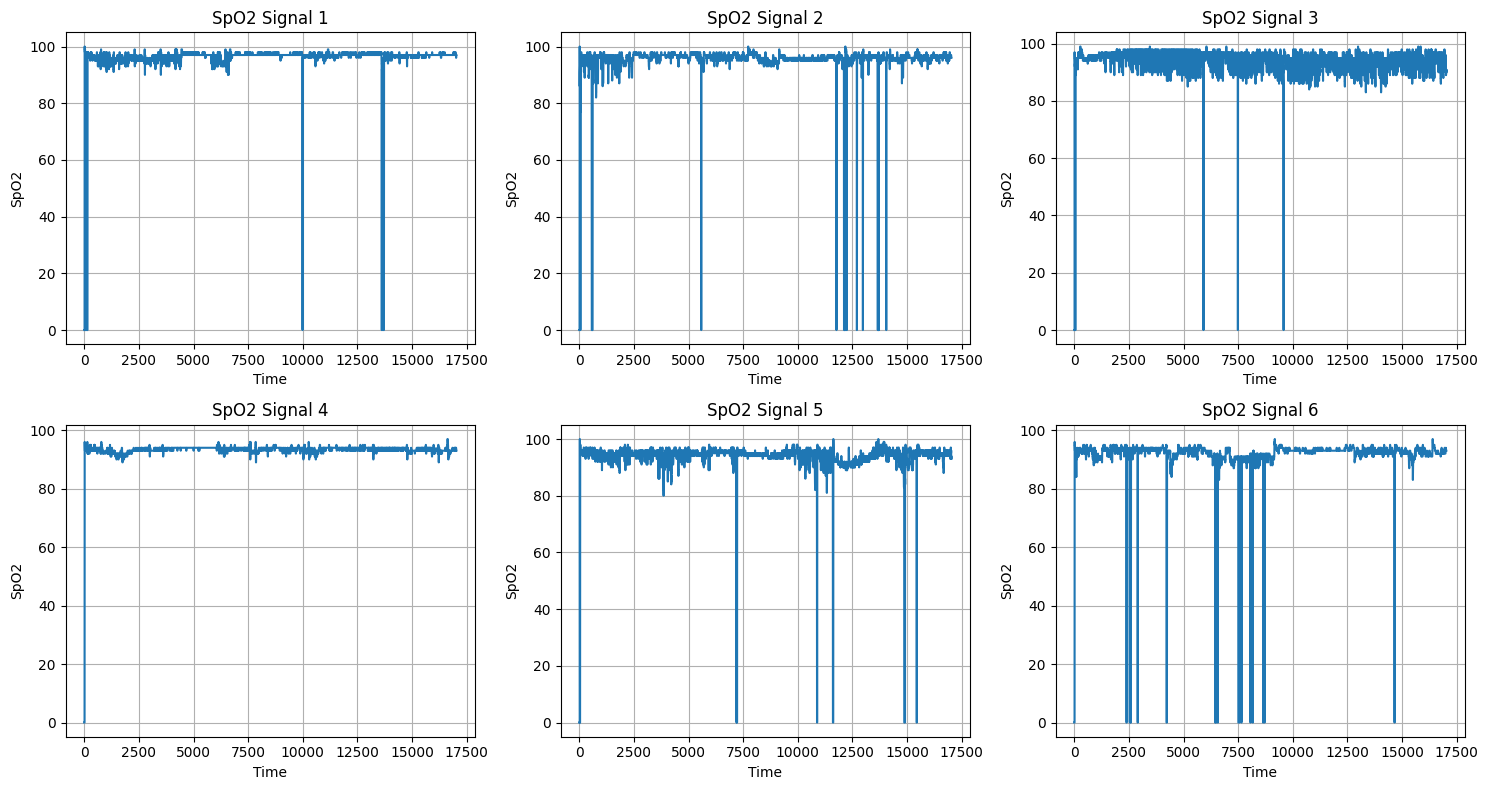

In [5]:
# Take first 100 signals and find minimum length
first_100 = df_list[:100]
signals_only = [signal for signal, patient in first_100]

# Find minimum length across all signals
min_length = min(len(signal) for signal in signals_only)
print(f"Minimum signal length: {min_length}")

# Truncate all signals to minimum length
truncated_signals = []
for signal in signals_only:
    truncated = signal[:min_length]
    # Reshape to (1, length) for 1D time series
    truncated_signals.append(truncated.reshape(1, -1))

print(f"Prepared {len(truncated_signals)} signals of length {min_length} for SSL training")

# Visualize a few signals
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(truncated_signals[i][0])
    plt.title(f'SpO2 Signal {i+1}')
    plt.xlabel('Time')
    plt.ylabel('SpO2')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Analyze signal statistics
print("Signal Statistics:")
print(f"Number of signals: {len(truncated_signals)}")
print(f"Signal length: {min_length}")
print(f"Signal shape: {truncated_signals[0].shape}")

# Check for data quality
sample_signal = truncated_signals[0][0]
print(f"\nSample signal stats:")
print(f"Mean: {np.mean(sample_signal):.2f}")
print(f"Std: {np.std(sample_signal):.2f}")
print(f"Min: {np.min(sample_signal):.2f}")
print(f"Max: {np.max(sample_signal):.2f}")
print(f"Zeros: {np.sum(sample_signal == 0)}")

# Check all signals for zeros
zero_counts = [np.sum(signal[0] == 0) for signal in truncated_signals]
print(f"\nZero statistics across all signals:")
print(f"Average zeros per signal: {np.mean(zero_counts):.1f}")
print(f"Max zeros in a signal: {np.max(zero_counts)}")
print(f"Signals with >50% zeros: {sum(1 for zc in zero_counts if zc > min_length/2)}")

Signal Statistics:
Number of signals: 100
Signal length: 17028
Signal shape: (1, 17028)

Sample signal stats:
Mean: 95.78
Std: 8.64
Min: 0.00
Max: 100.00
Zeros: 135

Zero statistics across all signals:
Average zeros per signal: 812.1
Max zeros in a signal: 11566
Signals with >50% zeros: 1


In [7]:
# Import SSL utility functions
import sys
sys.path.append('.')  # Add current directory to path
from ssl_utils import train_ssl

print("Starting SSL training on SpO2 data...")

Starting SSL training on SpO2 data...


Original signal shape: torch.Size([1, 1, 17028])
Labels for transformations: tensor([1, 0, 1, 0])


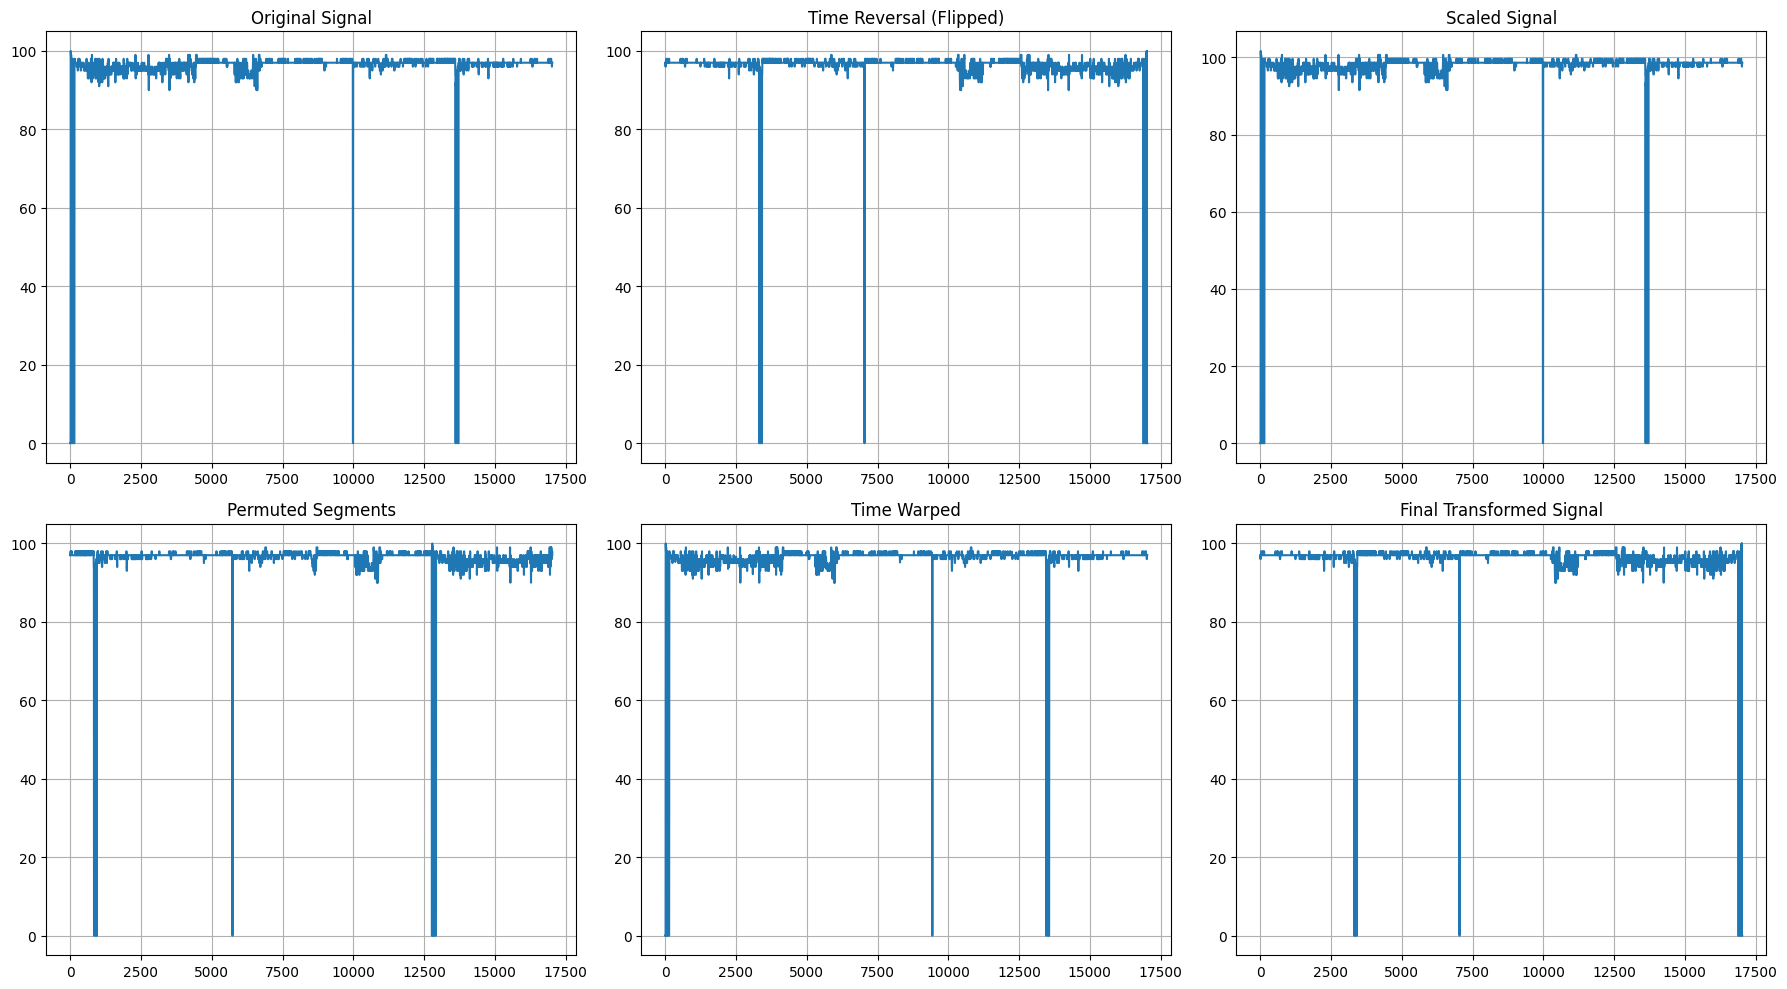

✅ Signal transformations are working!
Original signal range: [0.00, 100.00]
Transformed signal range: [0.00, 100.00]


In [8]:
# Visualize signal transformations to verify pretext tasks
import torch
from ssl_new_pipeline import (flip_time_series, scale_time_series, 
                             permute_time_series, time_warp_time_series,
                             generate_pretext_labels_and_transform)

# Take a sample signal for transformation demo
sample_signal = torch.tensor(truncated_signals[0], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
print(f"Original signal shape: {sample_signal.shape}")

# Create SSL config for transformations
ssl_config = {
    'time_reversal': True,
    'scale': True, 
    'permutation': True,
    'time_warped': True,
    'positive_ratio': 0.5
}

# Generate transformations
x_transformed, labels = generate_pretext_labels_and_transform(sample_signal, ssl_config)
print(f"Labels for transformations: {labels[0]}")  # [time_reversal, scale, permutation, time_warped]

# Plot original vs transformed
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original signal
axes[0, 0].plot(sample_signal[0, 0].numpy())
axes[0, 0].set_title('Original Signal')
axes[0, 0].grid(True)

# Individual transformations for visualization
test_signal = sample_signal.clone()

# Time reversal
flipped = flip_time_series(test_signal, 1)
axes[0, 1].plot(flipped[0, 0].numpy())
axes[0, 1].set_title('Time Reversal (Flipped)')
axes[0, 1].grid(True)

# Scaling
scaled = scale_time_series(test_signal, 1)
axes[0, 2].plot(scaled[0, 0].numpy())
axes[0, 2].set_title('Scaled Signal')
axes[0, 2].grid(True)

# Permutation
permuted = permute_time_series(test_signal, 1)
axes[1, 0].plot(permuted[0, 0].numpy())
axes[1, 0].set_title('Permuted Segments')
axes[1, 0].grid(True)

# Time warping
warped = time_warp_time_series(test_signal, 1)
axes[1, 1].plot(warped[0, 0].numpy())
axes[1, 1].set_title('Time Warped')
axes[1, 1].grid(True)

# Combined transformation (what actually gets fed to model)
axes[1, 2].plot(x_transformed[0, 0].numpy())
axes[1, 2].set_title('Final Transformed Signal')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

print("✅ Signal transformations are working!")
print(f"Original signal range: [{sample_signal.min():.2f}, {sample_signal.max():.2f}]")
print(f"Transformed signal range: [{x_transformed.min():.2f}, {x_transformed.max():.2f}]")

🚀 Starting Enhanced SSL Training with Progress Tracking
SSL Config: {'time_reversal': True, 'scale': True, 'permutation': True, 'time_warped': True, 'positive_ratio': 0.5}
Detected 1 channels
Target signal length: 17028
Number of signals: 100
Active SSL tasks: ['time_reversal', 'scale', 'permutation', 'time_warped']
🚀 Training SSL model with tasks: ['time_reversal', 'scale', 'permutation', 'time_warped']
📊 Dataset: 100 signals, 1 channels, length 17028
⚙️  Training: 20 epochs, batch size 16, lr 0.0001

🔥 Starting SSL Training...

🔥 Starting SSL Training...


🎯 SSL Epochs:   5%|▌         | 1/20 [01:39<31:32, 99.62s/epoch]

📈 Epoch   1/20: Loss=0.7233 | Acc=0.5223 | time_reversal: 0.464 | scale: 0.688 | permutation: 0.411 | time_warped: 0.527 | Time=99.6s


🎯 SSL Epochs:  10%|█         | 2/20 [03:33<32:20, 107.80s/epoch]

📈 Epoch   2/20: Loss=0.6834 | Acc=0.5804 | time_reversal: 0.518 | scale: 0.759 | permutation: 0.482 | time_warped: 0.562 | Time=113.5s


🎯 SSL Epochs:  15%|█▌        | 3/20 [05:12<29:29, 104.06s/epoch]

📈 Epoch   3/20: Loss=0.6586 | Acc=0.5982 | time_reversal: 0.536 | scale: 0.821 | permutation: 0.473 | time_warped: 0.562 | Time=99.6s


🎯 SSL Epochs:  20%|██        | 4/20 [07:54<33:50, 126.90s/epoch]

📈 Epoch   4/20: Loss=0.6528 | Acc=0.5826 | time_reversal: 0.518 | scale: 0.839 | permutation: 0.500 | time_warped: 0.473 | Time=161.9s


🎯 SSL Epochs:  25%|██▌       | 5/20 [09:58<31:26, 125.80s/epoch]

📈 Epoch   5/20: Loss=0.6316 | Acc=0.6362 | time_reversal: 0.589 | scale: 0.759 | permutation: 0.616 | time_warped: 0.580 | Time=123.8s


🎯 SSL Epochs:  30%|███       | 6/20 [11:50<28:15, 121.08s/epoch]

📈 Epoch   6/20: Loss=0.6629 | Acc=0.5469 | time_reversal: 0.473 | scale: 0.741 | permutation: 0.429 | time_warped: 0.545 | Time=111.9s


🎯 SSL Epochs:  35%|███▌      | 7/20 [13:31<24:48, 114.46s/epoch]

📈 Epoch   7/20: Loss=0.6653 | Acc=0.5424 | time_reversal: 0.598 | scale: 0.679 | permutation: 0.420 | time_warped: 0.473 | Time=100.8s


🎯 SSL Epochs:  40%|████      | 8/20 [15:32<23:18, 116.56s/epoch]

📈 Epoch   8/20: Loss=0.6622 | Acc=0.5759 | time_reversal: 0.491 | scale: 0.741 | permutation: 0.500 | time_warped: 0.571 | Time=121.0s


🎯 SSL Epochs:  45%|████▌     | 9/20 [17:22<20:58, 114.44s/epoch]

📈 Epoch   9/20: Loss=0.6522 | Acc=0.6049 | time_reversal: 0.562 | scale: 0.759 | permutation: 0.554 | time_warped: 0.545 | Time=109.8s


🎯 SSL Epochs:  50%|█████     | 10/20 [18:46<17:32, 105.28s/epoch]

📈 Epoch  10/20: Loss=0.6474 | Acc=0.5513 | time_reversal: 0.420 | scale: 0.768 | permutation: 0.420 | time_warped: 0.598 | Time=84.8s


🎯 SSL Epochs:  55%|█████▌    | 11/20 [20:19<15:11, 101.31s/epoch]

📈 Epoch  11/20: Loss=0.6783 | Acc=0.5848 | time_reversal: 0.536 | scale: 0.705 | permutation: 0.562 | time_warped: 0.536 | Time=92.3s


🎯 SSL Epochs:  60%|██████    | 12/20 [22:03<13:36, 102.08s/epoch]

📈 Epoch  12/20: Loss=0.6396 | Acc=0.6027 | time_reversal: 0.491 | scale: 0.777 | permutation: 0.589 | time_warped: 0.554 | Time=103.8s


🎯 SSL Epochs:  65%|██████▌   | 13/20 [25:41<16:02, 137.48s/epoch]

📈 Epoch  13/20: Loss=0.6668 | Acc=0.5625 | time_reversal: 0.518 | scale: 0.723 | permutation: 0.527 | time_warped: 0.482 | Time=218.9s


🎯 SSL Epochs:  70%|███████   | 14/20 [28:35<14:50, 148.48s/epoch]

📈 Epoch  14/20: Loss=0.6415 | Acc=0.5804 | time_reversal: 0.482 | scale: 0.812 | permutation: 0.411 | time_warped: 0.616 | Time=173.9s


🎯 SSL Epochs:  75%|███████▌  | 15/20 [30:17<11:11, 134.27s/epoch]

📈 Epoch  15/20: Loss=0.6715 | Acc=0.5603 | time_reversal: 0.455 | scale: 0.741 | permutation: 0.518 | time_warped: 0.527 | Time=101.3s


🎯 SSL Epochs:  80%|████████  | 16/20 [31:55<08:13, 123.34s/epoch]

📈 Epoch  16/20: Loss=0.6496 | Acc=0.5938 | time_reversal: 0.536 | scale: 0.777 | permutation: 0.464 | time_warped: 0.598 | Time=97.9s


🎯 SSL Epochs:  85%|████████▌ | 17/20 [33:59<06:11, 123.76s/epoch]

📈 Epoch  17/20: Loss=0.6403 | Acc=0.5915 | time_reversal: 0.580 | scale: 0.732 | permutation: 0.411 | time_warped: 0.643 | Time=124.7s


🎯 SSL Epochs:  90%|█████████ | 18/20 [35:59<04:05, 122.60s/epoch]

📈 Epoch  18/20: Loss=0.6521 | Acc=0.5960 | time_reversal: 0.464 | scale: 0.759 | permutation: 0.446 | time_warped: 0.714 | Time=119.9s


🎯 SSL Epochs:  95%|█████████▌| 19/20 [38:19<02:07, 127.85s/epoch]

📈 Epoch  19/20: Loss=0.6173 | Acc=0.6629 | time_reversal: 0.571 | scale: 0.812 | permutation: 0.438 | time_warped: 0.830 | Time=140.1s


🎯 SSL Epochs: 100%|██████████| 20/20 [40:01<00:00, 120.07s/epoch]



📈 Epoch  20/20: Loss=0.6237 | Acc=0.6161 | time_reversal: 0.464 | scale: 0.741 | permutation: 0.536 | time_warped: 0.723 | Time=101.5s

✅ SSL Training Complete! Total time: 2401.4s
📊 Final metrics: Loss=0.6237, Acc=0.6161


c:\Users\PC\ssl\ssl_new\ssl_utils.py:569: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\PC\ssl\ssl_new\ssl_utils.py:569: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\PC\ssl\ssl_new\ssl_utils.py:569: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\PC\ssl\ssl_new\ssl_utils.py:569: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\PC\ssl\ssl_new\ssl_utils.py:569: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\PC\ssl\ssl_new\ssl_utils.py:569: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\PC\ssl\ssl_new\ssl_utils.py:570: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig('ssl_tr

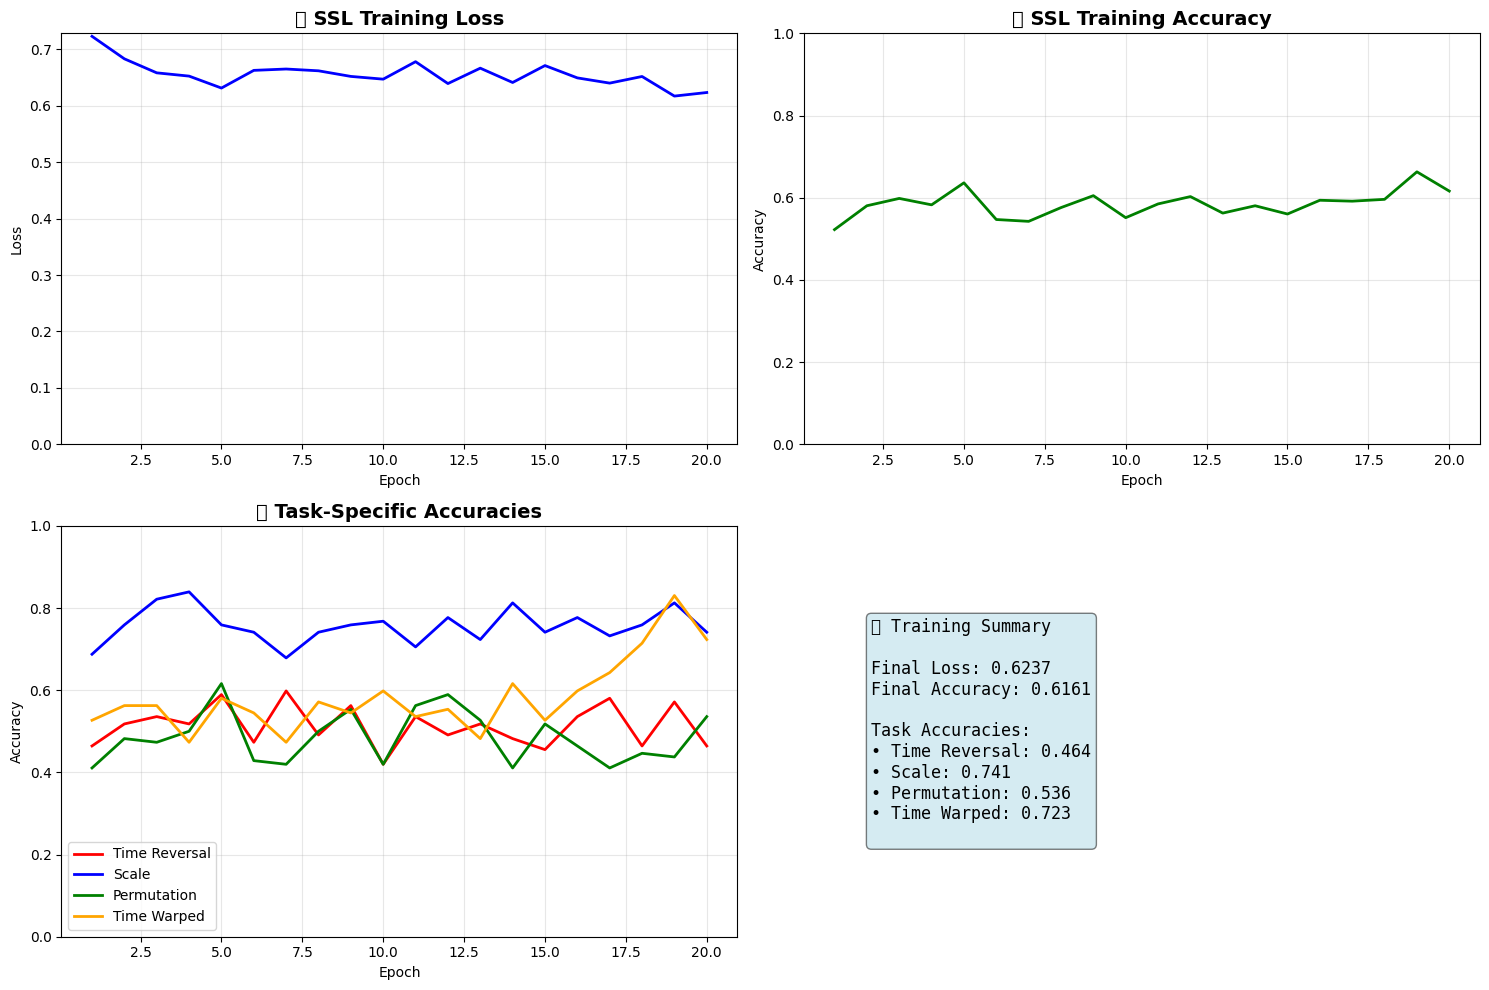

📊 Training progress plot saved as 'ssl_training_progress.png'
SSL model saved to: spo2_ssl_model_enhanced.pth


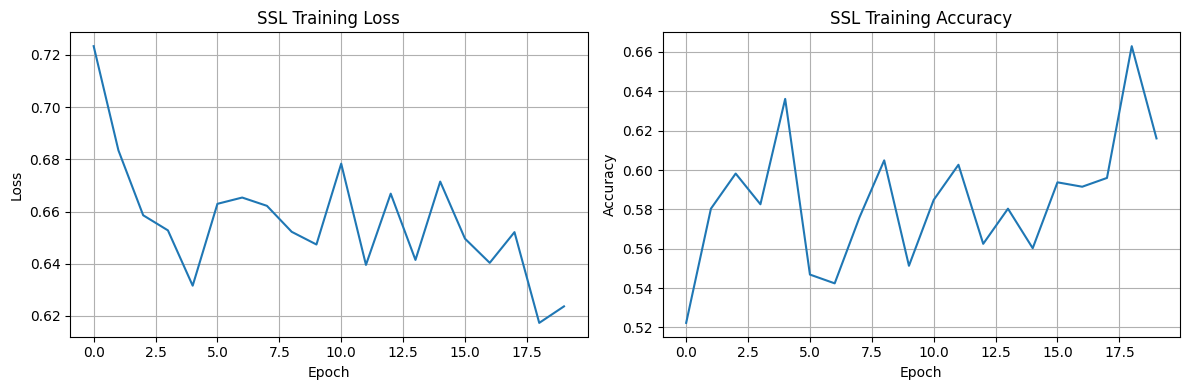


✅ SSL training completed! Model saved to: spo2_ssl_model_enhanced.pth
🎯 Check the training progress plots above!


In [9]:
# Train SSL model on SpO2 signals with enhanced progress tracking
print("🚀 Starting Enhanced SSL Training with Progress Tracking")
print("="*60)

# Reload the updated ssl_utils module
import importlib
importlib.reload(sys.modules['ssl_utils'])
from ssl_utils import train_ssl

# Train with enhanced logging and progress bars
model_path = train_ssl(
    signals=truncated_signals,
    signal_length=min_length,
    epochs=20,  # Reduced for faster demo
    learning_rate=1e-4,
    batch_size=16,  # Smaller batch size for limited data
    model_save_path="spo2_ssl_model_enhanced.pth"
)

print(f"\n✅ SSL training completed! Model saved to: {model_path}")
print("🎯 Check the training progress plots above!")

# Key experimentation parameters

**Current Data Status:**
- Total available signals: ~390 SpO2 time series
- Currently using: 100 signals 
- How many to use for self supervised training, how many to use for downstream classification task
- how many pieces should we cut each signal into? Current length: ~20000 (all signals are not same length), Current piece per signal =1



###  1. Data Augmentation Parameters

**Critical parameters in transforms:**
- **scale_range**: [Ex: 0.05, 0.1 (current), 0.2, 0.3] - How much scaling variation?
- **max_segments**: [Ex: 2, 4 (current), 6, 8] - Complexity of permutation
- **sigma**: [Ex: 0.1, 0.2 (current), 0.3, 0.5] - Time warping factors for each segment N(1,sigma).
- **positive_ratio**: [Ex: 0.3, 0.5 (current), 0.7] - what percentage of training samples are augmented vs kept original?

###  2. Training Hyperparameters

**Learning dynamics:**
- **Learning rate**: [1e-5, 5e-5, 1e-4 (current), 5e-4, 1e-3] 
- **Epochs**: [10, 20 (current), 50, 100] 
- **Batch size**: [8, 16 (current), 32, 64] 
- **Optimizer**: [Adam (current), AdamW, SGD]
- **Learning rate schedule**: [Constant (current), Cosine, Step decay]

###  3. SSL Task Configuration

**Which pretext tasks work best:**
- **Single tasks**: Train with only one task at a time
- **Task combinations**: Which 2-3 tasks work best together?
- **Task weighting**: Equal (current) vs weighted loss for different tasks
- **Current SSL tasks**: [time_reversal (current), scale (current), permutation (current), time_warped (current)] - All 4 tasks enabled

###  4. Model Architecture

**ResNet1D structure:**
- **Model depth**: [Smaller (2 blocks), Current (4 blocks - current), Deeper (6 blocks)]
- **Channel progression**: [32-64-128-256] vs [64-128-256-512 (current)] vs [128-256-512-1024]
- **Kernel sizes**: [3 (current), 5, 7] in conv layers
- **Dropout rates**: [0.0 (current), 0.1, 0.2, 0.3] for regularization

###  5. Data Preprocessing

**Signal preparation:**
- **Signal length**: [5000, 10000, 17028 (current,=min length of available signals), 25000] samples
- **Normalization**: [None (current), Z-score, Min-Max, Robust scaling]
- **Filtering**: [No filter (current), Low-pass, Band-pass] for noise removal
- **Sampling strategies**: [Random segments, Sliding windows, Overlapping]



---

Input (C=1, length~20000)
   │
   ▼
Conv1d(in=1, out=64, kernel=7, stride=2, padding=3)
BatchNorm1d(64)
ReLU
# Suggestion: Could use pre-activation here (BN → ReLU → Conv) for better gradient flow
   │
   ▼
ResNet Blocks:
   ├─ Layer1: [BasicBlock(64)] x 2
   │   # Suggestion: Consider Res2Net blocks for multi-scale feature learning
   ├─ Layer2: [BasicBlock(128)] x 2 (stride=2 on first block)
   │   # Suggestion: Optionally add Channel Attention (SE or CBAM) to highlight important features
   ├─ Layer3: [BasicBlock(256)] x 2 (stride=2 on first block)
   └─ Layer4: [BasicBlock(512)] x 2 (stride=2 on first block)
       # Suggestion: Apply Stochastic Depth (DropPath) for regularization
   │
   ▼
AdaptiveAvgPool1d(1)
# Suggestion: Can add Dropout before flattening to reduce overfitting
   ▼
Flatten → Feature vector (512-dim)
   │
   ├─ Head "time_reversal": Linear(512 → 2)
   │   # Suggestion: Use task-specific activation/loss if tasks are heterogeneous
   ├─ Head "scale":         Linear(512 → 2)
   ├─ Head "permutation":   Linear(512 → 2)
   └─ Head "time_warped":   Linear(512 → 2)
# Suggestion: Consider multi-task learning techniques if heads are related
